# Introduction
I decided to use the Motion Capture Hand Postures Dataset. I sourced this data from UCI's repository: http://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#

Central Question that will be explored:
The dataset captures 5 different hand positions and conntains coordinates in a 3-D space related to the legend above. My goal here is to be able to cluster the data together based on the coordinates so that I can properly predict what hand position is being made. I hope to find the most precise mechanism that can cluster the groups based on their positions. I will use unsupervised learning methods (mini batch K means, and GMM) and data visualization techniques to find the best model for clustering my data. 

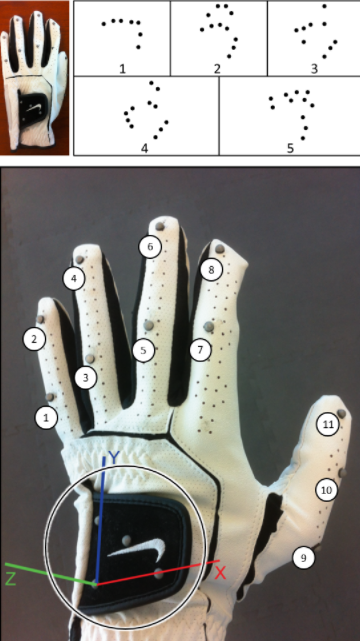

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, boxcox
from scipy.stats.mstats import winsorize
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

import time
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from statistics import mean

In [2]:
import io
df = pd.read_csv("Postures.csv")

In [3]:
df.head()
#X,Y,Z all represent coordinates on a 3-D plane and the numbers ie. X1, Y2 etc
#correspond to the numbers in the image above

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


In [4]:
#omitting first row since it is all null
df=df[1:]
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,?,?,?,?,?,?,?,?,?,?


In [5]:
#making a copy of df to preserve original and work with copied frame 
df_copy = df
df_copy2 = df

In [6]:
#cleaning up df to get rid of symbols
df_copy = df_copy.replace('?', np.nan)
df_copy2 = df_copy2.replace('?', 0)

In [7]:
#checking for count of null values
null_values = df_copy.isnull().sum()
null_values[null_values>0]

X3       690
Y3       690
Z3       690
X4      3120
Y4      3120
Z4      3120
X5     13023
Y5     13023
Z5     13023
X6     25848
Y6     25848
Z6     25848
X7     39152
Y7     39152
Z7     39152
X8     47532
Y8     47532
Z8     47532
X9     54128
Y9     54128
Z9     54128
X10    63343
Y10    63343
Z10    63343
X11    78064
Y11    78064
Z11    78064
dtype: int64

In [8]:
#HUGE number of null values so cannot drop rows otherwise will be left with barely any data
#breaking down the dfs so that they will be easier to work with
#less nulls in a smaller sample size 
df_4 = df_copy.drop(['X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_5 = df_copy.drop(['X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_6 = df_copy.drop(['X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_7 = df_copy.drop(['X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_8 = df_copy.drop(['X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_9 = df_copy.drop(['X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
#creating four dfs based on the coordinates related to each hand section
#another method to create smaller clusters of data
df_nothumbnail = df_copy2.drop(['X11', 'Y11', 'Z11'], axis=1)
df_nothumb = df_copy2.drop(['X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], axis=1)
df_noknuckle = df_copy2.drop(['X1', 'Y1', 'Z1', 'X3', 'Y3', 'Z3', 'X5', 'Y5', 'Z5', 'X7', 'Y7', 'Z7'], axis=1)
df_selected = df_copy2[['Class', 'User', 'X2', 'Y2', 'Z2', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8']]

In [9]:
#removing nulls from dfs 4-9
df_4.dropna(inplace=True)
df_5.dropna(inplace=True)
df_6.dropna(inplace=True)
df_7.dropna(inplace=True)
df_8.dropna(inplace=True)
df_9.dropna(inplace=True)


In [10]:
#naming dfs for formality to be referenced throughout analysis
df_copy.name = 'df_copy'
df_4.name = 'df_4'
df_5.name = 'df_5'
df_6.name = 'df_6'
df_7.name = 'df_7'
df_8.name = 'df_8'
df_9.name = 'df_9'
df_copy2.name = 'df_copy2'
df_nothumbnail.name = 'df_nothumbnail'
df_nothumb.name = 'df_nothumb'
df_noknuckle.name = 'df_noknuckle'
df_selected.name = 'df_selected'

In [11]:
#defining functions and creating variables and standardizing variables 
def target_feature_scalar(df):


  global X, y, X_std, name

  
  X = df.drop(['Class', 'User'], axis=1)
  y = df['Class']

  # Standarizing features
  scaler = StandardScaler()
  X_std = scaler.fit_transform(X)

  name = df.name
  return X_std

In [12]:
#defining ARI score to be used later as a metric
def ari(predict):
  return metrics.adjusted_rand_score(y, predict)

In [13]:
#defining Siloutte score function to be used later as a metric
def silhouette(predict):
  return metrics.silhouette_score(X_std, predict, metric='euclidean')

In [14]:
# defining function to create a table of cluster numbers, ARI scores and Silhouette scores
# inputs are range start and end (clusters X through Y), df, and which model was used 
def scores_table(range_start, range_end, df, model):
  ari_scores = []
  silhouette_scores = []
  for i in range(range_start,range_end):
    model(i, df)
    ari_scores.append(ari(y_pred))
    silhouette_scores.append(silhouette(y_pred))

  metric_scores = pd.DataFrame()
  metric_scores['ARI Scores'] = ari_scores
  metric_scores['Silhouette Scores'] = silhouette_scores
  metric_scores.set_index(pd.Series(range(range_start,range_end),  name='Cluster Number'))

  print (metric_scores.set_index(pd.Series(range(range_start,range_end),  name='Cluster Number')))



In [15]:
#starting out here with mini batch K means 
def minikmeans_function(n, df):
 
  global minikmeans_cluster, y_pred

  minikmeans_cluster = MiniBatchKMeans(
    init='random',
    n_clusters=n,
    batch_size=50)

  # fitting model
  %timeit minikmeans_cluster.fit(X_std)
  y_pred = minikmeans_cluster.predict(X_std)

  # adding a column to the df to compare clusters to original classes
  df['Cluster Predictions'] = y_pred


In [16]:
#using mini batch k means to find the best performing df to use on other models
for i in [df_4, df_5, df_6, df_7, df_8, df_9, df_nothumbnail, df_nothumb, df_noknuckle, df_selected]:
  target_feature_scalar(i)
  scores_table(2, 10, i, minikmeans_function)
  print ('ARI and Silhouette Scores for ' + str(i.name) + '\n')

526 ms ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
559 ms ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
677 ms ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
487 ms ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
681 ms ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
684 ms ± 368 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
548 ms ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.30 times longer than the fastest. This could mean that an intermediate result is being cached.
723 ms ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                ARI Scores  Silhouette Scores
Cluster Number                               
2                 0.123061           0.173614
3                 0.117263           0.137123
4                 0.125283           0.109502
5                 0.135304           0.125707
6                 0.123963           0.108085
7                 0.1197

<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


373 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


424 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


389 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


418 ms ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


413 ms ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


472 ms ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


471 ms ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-15-378b1bf168a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Predictions'] = y_pred


                ARI Scores  Silhouette Scores
Cluster Number                               
2                 0.277991           0.221252
3                 0.305767           0.119069
4                 0.270139           0.124850
5                 0.268916           0.139220
6                 0.234941           0.112016
7                 0.200051           0.116780
8                 0.204916           0.106737
9                 0.200318           0.119348
ARI and Silhouette Scores for df_selected



In [17]:
#df_nothumb had the best ARI score and so we will use this df for analysis 
#using Elbow method to determine the best number of clusters to use going forward
wcss=[]

for i in range(1,10):
  minikmeans_function(i, df_nothumb)
  wcss_iter = minikmeans_cluster.inertia_
  wcss.append(wcss_iter)

247 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
375 ms ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
335 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
387 ms ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
374 ms ± 206 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
339 ms ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
370 ms ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
451 ms ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
428 ms ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


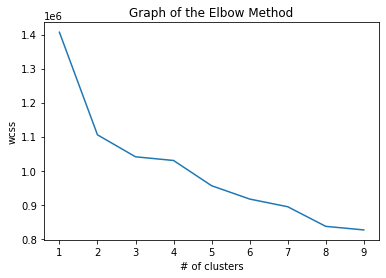

In [18]:
number_clusters = range(1,10)
plt.plot(number_clusters, wcss)
plt.title('Graph of the Elbow Method')
plt.xlabel('# of clusters')
plt.ylabel('wcss')
plt.show()

In [19]:
#checking performance of mini-batch kmeans with df_nothumb and five clusters
avg_ari_score = []
for i in range(5):
  target_feature_scalar(df_nothumb)
  minikmeans_function(5, df_nothumb)
  avg_ari_score.append(ari(y_pred))

print ('Average ARI score for minibatch k-means: {}'.format(mean(avg_ari_score)))

422 ms ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
434 ms ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
294 ms ± 79.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
504 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
462 ms ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average ARI score for minibatch k-means: 0.2706239500705


In [20]:
#now trying out GMM as my next model 
def gmm_function(n, df, maxiter, covariancetype, ninit):
  

  global gmm_cluster, y_pred

  gmm_cluster = GaussianMixture(n_components=n, random_state=123, max_iter=maxiter, covariance_type=covariancetype, n_init=ninit)


  # fitting model
  %timeit gmm_cluster.fit(X_std)
  y_pred = gmm_cluster.predict(X_std)


In [22]:
# Running GMM on test data
avg_ari_score = []
for i in range(5):
  target_feature_scalar(df_nothumb)
  gmm_function(5, df_nothumb, 100, 'full', 1)
  avg_ari_score.append(ari(y_pred))

print ('Average ARI score for GMM: {}'.format(mean(avg_ari_score)))

6.53 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.42 s ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.65 s ± 285 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.23 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.26 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average ARI score for GMM: 0.2939290225606318


In [23]:
#now time for visualization
#setting up for PCA
def pca_function(n, d):



  global pca, y_pred
  

  pca = PCA(n_components=n)


  pca = pca.fit_transform(d)

  df_subset = pd.DataFrame()
  df_subset['pca_one'] = pca[:,0]
  df_subset['pca_two'] = pca[:,1]



  return pca

In [24]:
#using SNS for visualization 
def snsgraph_function(drf, num_clusters):

  df_subset = pd.DataFrame()
  df_subset['First Component'] = drf[:,0]
  df_subset['Second Component'] = drf[:,1]

  plt.figure(figsize=(16,10))
  sns.scatterplot(
    x=str(df_subset.columns[0]), y=str(df_subset.columns[1]),
    hue=y,
    palette=sns.color_palette("deep", num_clusters),
    data=df_subset,
    legend="full",
    alpha=0.8)
  
  plt.title(name)

In [25]:
#actually visualizing PCA now
pca_function(2, X_std)

array([[ 3.65440742,  0.18749931],
       [ 3.61050975,  0.59894758],
       [ 3.62088438,  0.59126871],
       ...,
       [-2.08923963,  0.42926056],
       [-3.06140948, -0.58350055],
       [-2.8934023 ,  0.68102209]])

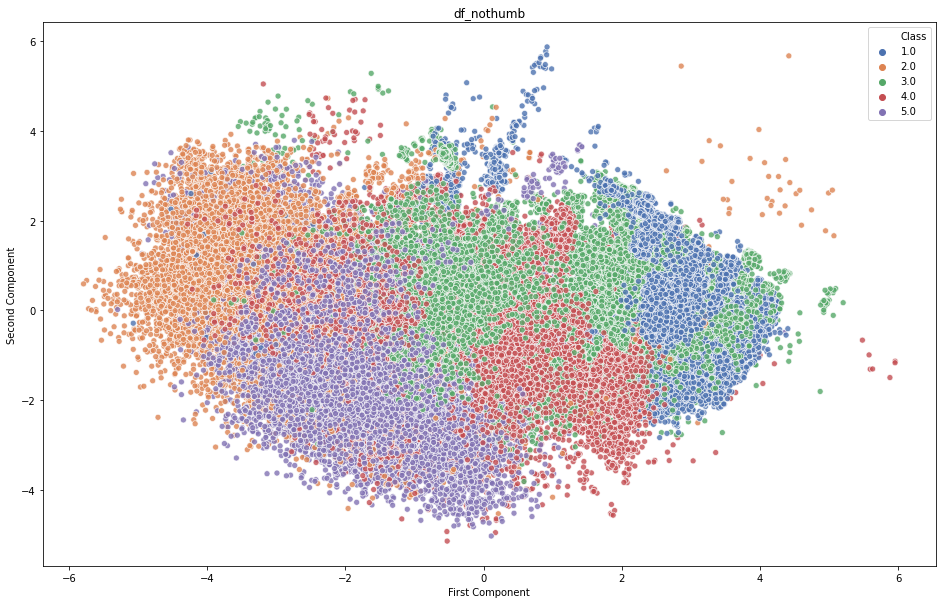

In [26]:
snsgraph_function(pca, 5)

# Conclusion
GMM clearly gave the better ARI score and PCA nicely showed the different clusters--most prompinent were clusters 2 and 5 which makes sense because those hand gestures are opposites of each other. 